<a href="https://colab.research.google.com/github/kejohns19/Udacity_DRLN/blob/master/Pong/Pong_REINFORCE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://raw.githubusercontent.com/kejohns19/Udacity_DRLN/master/Pong/parallelEnv.py
!wget https://raw.githubusercontent.com/kejohns19/Udacity_DRLN/master/Pong/pong_utils.py
!wget https://raw.githubusercontent.com/kejohns19/Udacity_DRLN/master/Pong/REINFORCE.policy

--2020-09-07 10:48:36--  https://raw.githubusercontent.com/kejohns19/Udacity_DRLN/master/parallelEnv.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5625 (5.5K) [text/plain]
Saving to: ‘parallelEnv.py’

parallelEnv.py      100%[===================>]   5.49K  --.-KB/s    in 0s      

2020-09-07 10:48:36 (66.1 MB/s) - ‘parallelEnv.py’ saved [5625/5625]

--2020-09-07 10:48:36--  https://raw.githubusercontent.com/kejohns19/Udacity_DRLN/master/pong_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12204 (12K) [text/plain]
Saving to: ‘p

In [6]:
# install package for displaying animation
!pip install JSAnimation

# custom utilies for displaying animation, collecting rollouts and more
import pong_utils

%matplotlib inline

# check which device is being used. 
# I recommend disabling gpu until you've made sure that the code runs
device = pong_utils.device
print("using device: ",device)

using device:  cpu


In [7]:
# render ai gym environment
import gym
import time

# PongDeterministic does not contain random frameskip
# so is faster to train than the vanilla Pong-v4 environment
env = gym.make('PongDeterministic-v4')

print("List of available actions: ", env.unwrapped.get_action_meanings())

# we will only use the actions 'RIGHTFIRE' = 4 and 'LEFTFIRE" = 5
# the 'FIRE' part ensures that the game starts again after losing a life
# the actions are hard-coded in pong_utils.py

List of available actions:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


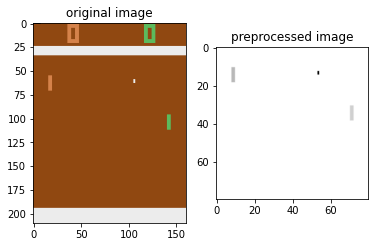

In [8]:
import matplotlib
import matplotlib.pyplot as plt

# show what a preprocessed image looks like
env.reset()
_, _, _, _ = env.step(0)
# get a frame after 20 steps
for _ in range(50):
    frame, _, _, _ = env.step(1)

plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original image')

plt.subplot(1,2,2)
plt.title('preprocessed image')

# 80 x 80 black and white image
plt.imshow(pong_utils.preprocess_single(frame), cmap='Greys')
plt.show()

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F



# set up a convolutional neural net
# the output is the probability of moving right
# P(left) = 1-P(right)
class Policy(nn.Module):

    def __init__(self):
        super(Policy, self).__init__()
        
        
    ########
    ## 
    ## Modify your neural network
    ##
    ########
        
        # 80x80 to outputsize x outputsize
        # outputsize = (inputsize - kernel_size + stride)/stride 
        # (round up if not an integer)

        # output = 20x20 here
        self.conv1 = nn.Conv2d(2, 16, kernel_size=4, stride=4)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=2)
        self.size=32*9*9
        
        # 1 fully connected layer
        self.fc1 = nn.Linear(self.size, 128)
        self.fc2 = nn.Linear(128,1)
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        
    ########
    ## 
    ## Modify your neural network
    ##
    ########
    
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        # flatten the tensor
        x = x.view(-1,self.size)
        x = F.relu(self.fc1(x))
        return self.sig(self.fc2(x))

# use your own policy!
policy=Policy().to(device)


#policy=pong_utils.Policy().to(device)

# we use the adam optimizer with learning rate 2e-4
# optim.SGD is also possible
import torch.optim as optim
optimizer = optim.Adam(policy.parameters(), lr=2e-4)

In [10]:
envs = pong_utils.parallelEnv('PongDeterministic-v4', n=4, seed=12345)
prob, state, action, reward = pong_utils.collect_trajectories(envs, policy, tmax=100)

In [14]:
[(x[0], x[1]) for x in reward if x[0] !=  0]

[(-1.0, 0.0), (-1.0, 0.0), (-1.0, 0.0), (-1.0, 0.0), (-1.0, 0.0)]

In [15]:
import numpy as np

def surrogate(policy, old_probs, states, actions, rewards,
              discount = 0.995, beta=0.01):

    ########
    ## 
    ## WRITE YOUR OWN CODE HERE
    ##
    ########
    
    discount = discount**np.arange(len(rewards))
    rewards = np.asarray(rewards)*discount[:,np.newaxis]
    
    # convert rewards to future rewards
    rewards_future = rewards[::-1].cumsum(axis=0)[::-1]
  
    mean = np.mean(rewards_future, axis=1)
    std = np.std(rewards_future, axis=1) + 1.0e-10
    
    rewards_normalized = (rewards_future - mean[:,np.newaxis])/std[:,np.newaxis]
    
    # convert everything into pytorch tensors and move to gpu if available
    actions = torch.tensor(actions, dtype=torch.int8, device=device)
    old_probs = torch.tensor(old_probs, dtype=torch.float, device=device)
    rewards = torch.tensor(rewards_normalized, dtype=torch.float, device=device)
    
    # convert states to policy (or probability)
    new_probs = pong_utils.states_to_prob(policy, states)
    new_probs = torch.where(actions == pong_utils.RIGHT, new_probs, 1.0-new_probs)
    
    ratio = new_probs/old_probs

    # include a regularization term
    # this steers new_policy towards 0.5
    # which prevents policy to become exactly 0 or 1
    # this helps with exploration
    # add in 1.e-10 to avoid log(0) which gives nan
    entropy = -(new_probs*torch.log(old_probs+1.e-10)+ \
        (1.0-new_probs)*torch.log(1.0-old_probs+1.e-10))

    return torch.mean(ratio*rewards + beta*entropy)


Lsur= surrogate(policy, prob, state, action, reward)

print(Lsur)

tensor(0.0069, grad_fn=<MeanBackward0>)


In [12]:
optimizer = optim.Adam(policy.parameters(), lr=1e-3)
from parallelEnv import parallelEnv
import numpy as np
# WARNING: running through all 800 episodes will take 30-45 minutes

# training loop max iterations
episode = 2000
# episode = 800

# widget bar to display progress
!pip install progressbar
import progressbar as pb
widget = ['training loop: ', pb.Percentage(), ' ', 
          pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episode).start()

# initialize environment
envs = parallelEnv('PongDeterministic-v4', n=8, seed=1234)

discount_rate = .99
beta = .05
tmax = 100

# keep track of progress
mean_rewards = []

for e in range(episode):

    # collect trajectories
    old_probs, states, actions, rewards = \
        pong_utils.collect_trajectories(envs, policy, tmax=tmax)
        
    total_rewards = np.sum(rewards, axis=0)

    # this is the SOLUTION!
    # use your own surrogate function
    L = -surrogate(policy, old_probs, states, actions, rewards, beta=beta)
    
    #L = -pong_utils.surrogate(policy, old_probs, states, actions, rewards, beta=beta)
    optimizer.zero_grad()
    L.backward()
    optimizer.step()
    del L
        
    # the regulation term also reduces
    # this reduces exploration in later runs
    beta*=.998
    
    # get the average reward of the parallel environments
    mean_rewards.append(np.mean(total_rewards))
    
    # display some progress every 20 iterations
    if (e+1)%20 ==0 :
        print("Episode: {0:d}, score: {1:f}, tmax: {2:d}".format(e+1,np.mean(total_rewards), tmax))
        print(total_rewards)
        
        # increase tmax
        if mean_rewards[-1] > -3:
            tmax += 10
        
    # update progress widget bar
    timer.update(e+1)
    
timer.finish()
    

Episode: 20, score: -3.625000, tmax: 100
[-4. -2. -4. -2. -2. -5. -5. -5.]


Episode: 40, score: -3.625000, tmax: 100
[-5. -1. -3. -5. -1. -4. -5. -5.]


Episode: 60, score: -4.000000, tmax: 100
[-5. -3. -4. -3. -5. -5. -3. -4.]


Episode: 80, score: -3.750000, tmax: 100
[-3. -4. -5. -4. -2. -4. -3. -5.]


Episode: 100, score: -3.875000, tmax: 100
[-2. -4. -5. -4. -5. -4. -4. -3.]


Episode: 120, score: -3.000000, tmax: 100
[-1. -1. -2. -5. -4. -4. -3. -4.]


Episode: 140, score: -2.500000, tmax: 100
[-4. -3. -1. -2. -3. -2. -2. -3.]


Episode: 160, score: -4.000000, tmax: 110
[-4. -4. -5. -4. -4. -3. -4. -4.]


Episode: 180, score: -3.875000, tmax: 110
[-3. -4. -4. -4. -4. -4. -4. -4.]


Episode: 200, score: -3.750000, tmax: 110
[-2. -4. -4. -4. -4. -4. -4. -4.]


Episode: 220, score: -3.125000, tmax: 110
[-2. -5. -3. -4. -4. -4. -3.  0.]


Episode: 240, score: -3.250000, tmax: 110
[-2. -3. -4. -2. -4. -4. -3. -4.]


Episode: 260, score: -3.375000, tmax: 110
[-2. -4. -4. -4. -4. -1. -4. -4.]


Episode: 280, score: -4.000000, tmax: 110
[-4. -4. -4. -4. -4. -4. -4. -4.]


Episode: 300, score: -2.625000, tmax: 110
[ 0. -4. -4.  0. -4. -4. -3. -2.]


Episode: 320, score: -4.000000, tmax: 120
[-5. -4. -4. -5. -4. -4. -3. -3.]


Episode: 340, score: -3.375000, tmax: 120
[-5.  0. -4. -2. -5. -3. -4. -4.]


Episode: 360, score: -3.125000, tmax: 120
[-1. -5. -4. -2. -4. -4. -3. -2.]


Episode: 380, score: -4.375000, tmax: 120
[-4. -4. -4. -4. -5. -4. -5. -5.]


Episode: 400, score: -3.750000, tmax: 120
[-4. -3. -5. -3. -5. -4. -2. -4.]


Episode: 420, score: -3.500000, tmax: 120
[-5. -4. -5. -4. -3. -2. -3. -2.]


Episode: 440, score: -3.250000, tmax: 120
[-4. -3. -4. -1. -4. -1. -5. -4.]


Episode: 460, score: -2.750000, tmax: 120
[-3. -4. -4.  0. -4.  1. -4. -4.]


Episode: 480, score: -4.000000, tmax: 130
[-1. -1. -6. -4. -5. -4. -5. -6.]


Episode: 500, score: -2.750000, tmax: 130
[-5. -1. -5. -3. -1. -3. -1. -3.]


Episode: 520, score: -3.000000, tmax: 140
[-4. -3. -1. -3. -4. -3. -5. -1.]


Episode: 540, score: -2.125000, tmax: 140
[-4. -1. -4.  0. -2. -4. -3.  1.]


Episode: 560, score: -3.875000, tmax: 150
[-3. -3. -2. -6. -2. -5. -6. -4.]


Episode: 580, score: -3.375000, tmax: 150
[-3. -5. -4.  0. -3. -5. -4. -3.]


Episode: 600, score: -2.250000, tmax: 150
[-1. -1. -2. -4. -2. -1. -5. -2.]


Episode: 620, score: -1.250000, tmax: 160
[-3. -1. -1.  0.  1. -2. -1. -3.]


Episode: 640, score: -1.625000, tmax: 170
[ 0.  0. -2. -4. -1. -4.  1. -3.]


Episode: 660, score: -2.250000, tmax: 180
[-4. -2.  0. -2. -3. -5.  0. -2.]


Episode: 680, score: -1.625000, tmax: 190
[-4. -2. -2. -1. -2.  1. -3.  0.]


Episode: 700, score: -2.625000, tmax: 200
[ 0. -2. -4. -5. -2. -2. -4. -2.]


Episode: 720, score: -1.000000, tmax: 210
[-1. -2. -3. -2.  0.  0.  0.  0.]


Episode: 740, score: -0.875000, tmax: 220
[ 0. -4.  0.  0. -2. -1.  0.  0.]


Episode: 760, score: -0.375000, tmax: 230
[-2.  0.  0.  0.  0.  0. -2.  1.]


Episode: 780, score: -0.750000, tmax: 240
[ 0.  0. -2. -2.  0. -2.  0.  0.]


Episode: 800, score: 0.750000, tmax: 250
[0. 1. 1. 1. 0. 0. 1. 2.]


Episode: 820, score: 0.125000, tmax: 260
[-3. -4.  3.  3.  3.  1.  1. -3.]


Episode: 840, score: -0.375000, tmax: 270
[-1.  2. -2.  1. -2.  2. -1. -2.]


Episode: 860, score: 0.750000, tmax: 280
[ 1.  2.  2. -3.  2.  2.  2. -2.]


Episode: 880, score: 0.500000, tmax: 290
[-5.  2.  2.  1.  2.  1.  2. -1.]


Episode: 900, score: 2.000000, tmax: 300
[2. 3. 2. 1. 2. 2. 2. 2.]


Episode: 920, score: 0.875000, tmax: 310
[ 2.  2.  2.  1.  2.  3. -7.  2.]


Episode: 940, score: 1.000000, tmax: 320
[-1.  2.  3.  1.  3. -4.  2.  2.]


Episode: 960, score: 3.000000, tmax: 330
[3. 3. 3. 3. 3. 3. 3. 3.]


Episode: 980, score: 2.500000, tmax: 340
[3. 3. 1. 3. 1. 3. 3. 3.]


Episode: 1000, score: 1.625000, tmax: 350
[ 3. -3.  3.  3.  3.  2. -1.  3.]


Episode: 1020, score: 4.000000, tmax: 360
[4. 4. 4. 4. 4. 4. 4. 4.]


Episode: 1040, score: 3.375000, tmax: 370
[4. 4. 4. 3. 2. 4. 4. 2.]


Episode: 1060, score: 4.000000, tmax: 380
[4. 4. 4. 4. 4. 4. 4. 4.]


Episode: 1080, score: 4.000000, tmax: 390
[4. 4. 4. 4. 4. 4. 4. 4.]


Episode: 1100, score: 4.625000, tmax: 400
[5. 5. 5. 5. 5. 2. 5. 5.]


Episode: 1120, score: 4.000000, tmax: 410
[3. 1. 5. 5. 3. 5. 5. 5.]


Episode: 1140, score: 4.125000, tmax: 420
[5. 5. 5. 3. 5. 0. 5. 5.]


Episode: 1160, score: 5.000000, tmax: 430
[5. 5. 5. 5. 5. 5. 5. 5.]


Episode: 1180, score: 4.500000, tmax: 440
[5. 5. 5. 5. 3. 5. 5. 3.]


Episode: 1200, score: 3.875000, tmax: 450
[4. 4. 4. 4. 4. 4. 3. 4.]


Episode: 1220, score: 3.875000, tmax: 460
[4. 4. 4. 4. 4. 3. 4. 4.]


Episode: 1240, score: 0.750000, tmax: 470
[  4.   4.   4.   4.   4.  -5. -13.   4.]


Episode: 1260, score: 4.000000, tmax: 480
[4. 4. 4. 4. 4. 4. 4. 4.]


Episode: 1280, score: 4.000000, tmax: 490
[4. 4. 4. 4. 4. 4. 4. 4.]


Episode: 1300, score: 4.750000, tmax: 500
[3. 5. 5. 5. 5. 5. 5. 5.]


Episode: 1320, score: 5.000000, tmax: 510
[5. 5. 5. 5. 5. 5. 5. 5.]


Episode: 1340, score: 5.000000, tmax: 520
[5. 5. 5. 5. 5. 5. 5. 5.]


Episode: 1360, score: 5.000000, tmax: 530
[5. 5. 5. 5. 5. 5. 5. 5.]


Episode: 1380, score: 5.750000, tmax: 540
[6. 6. 6. 6. 6. 6. 6. 4.]


Episode: 1400, score: 5.750000, tmax: 550
[6. 6. 6. 4. 6. 6. 6. 6.]


Episode: 1420, score: 5.500000, tmax: 560
[6. 6. 4. 4. 6. 6. 6. 6.]


Episode: 1440, score: 5.750000, tmax: 570
[6. 6. 6. 6. 6. 6. 4. 6.]


Episode: 1460, score: 6.250000, tmax: 580
[4. 7. 7. 4. 7. 7. 7. 7.]


Episode: 1480, score: 4.375000, tmax: 590
[  7.   7.   5.   7.   7.   7. -12.   7.]


Episode: 1500, score: 6.375000, tmax: 600
[7. 7. 7. 7. 7. 7. 2. 7.]


Episode: 1520, score: 7.000000, tmax: 610
[7. 7. 7. 7. 7. 7. 7. 7.]


Episode: 1540, score: 7.000000, tmax: 620
[7. 7. 7. 7. 7. 7. 7. 7.]


Episode: 1560, score: 6.000000, tmax: 630
[6. 6. 6. 6. 6. 6. 6. 6.]


Episode: 1580, score: 6.000000, tmax: 640
[6. 6. 6. 6. 6. 6. 6. 6.]


Episode: 1600, score: 6.125000, tmax: 650
[6. 6. 6. 6. 6. 6. 7. 6.]


Episode: 1620, score: 6.000000, tmax: 660
[6. 6. 6. 6. 6. 6. 6. 6.]


Episode: 1640, score: 6.125000, tmax: 670
[6. 6. 6. 6. 6. 6. 7. 6.]


Episode: 1660, score: 7.000000, tmax: 680
[7. 7. 7. 7. 7. 7. 7. 7.]


Episode: 1680, score: 7.000000, tmax: 690
[7. 7. 7. 7. 7. 7. 7. 7.]


Episode: 1700, score: 7.000000, tmax: 700
[7. 7. 7. 7. 7. 7. 7. 7.]


Episode: 1720, score: 7.000000, tmax: 710
[7. 7. 7. 7. 7. 7. 7. 7.]


Episode: 1740, score: 7.750000, tmax: 720
[8. 8. 8. 8. 8. 8. 6. 8.]


Process Process-25:
Process Process-23:
Process Process-21:
Traceback (most recent call last):
Process Process-28:
Process Process-24:
Process Process-22:
Process Process-27:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-26:
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  

KeyboardInterrupt: ignored

KeyboardInterrupt


In [13]:
# save your policy!
torch.save(policy, 'REINFORCE.policy')

In [17]:
import torch
policy = torch.load('REINFORCE.policy', map_location=torch.device('cpu'))

In [18]:
prob, state, action, reward = pong_utils.collect_trajectories(envs, policy, tmax=2000)

In [19]:
[(x[0], x[1]) for x in reward if x[0] !=  0]

[(1.0, 1.0),
 (-1.0, -1.0),
 (1.0, 1.0),
 (1.0, 1.0),
 (1.0, 1.0),
 (-1.0, -1.0),
 (1.0, 1.0),
 (1.0, 1.0),
 (1.0, 1.0),
 (-1.0, -1.0),
 (1.0, 1.0),
 (1.0, 1.0),
 (1.0, 1.0),
 (-1.0, -1.0),
 (1.0, 1.0),
 (1.0, 1.0),
 (1.0, 1.0),
 (-1.0, -1.0),
 (1.0, 1.0),
 (1.0, 1.0),
 (1.0, 1.0),
 (-1.0, -1.0),
 (1.0, 1.0),
 (1.0, 1.0),
 (1.0, 1.0),
 (-1.0, -1.0),
 (1.0, 1.0),
 (1.0, 1.0)]

In [20]:
torch.__version__

'1.6.0+cu101'